<a href="https://colab.research.google.com/github/XingruiWang/RUC-Deep-Learning-Course/blob/master/Homework/HW_4/%E7%8E%8B%E5%85%B4%E7%9D%BF_2017201690_DL_W04.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Homework 4: Comparison between Different Optimizers

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')
%cd /content/gdrive/My\ Drive/RUC/DeepLearning/course7
!ls

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).
/content/gdrive/My Drive/RUC/DeepLearning/course7
data_facescore	data_foodscore	FoodScore.csv  程序


### 一、载入函数包

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

import tensorflow as tf
from keras import Model, Input
from keras.layers import Dense,Flatten,Input
from keras.optimizers import SGD,RMSprop,Adam

from keras.utils import to_categorical 

In [ ]:
## loading mnist dataset
mnist = tf.keras.datasets.mnist
(X_train, y_train), (X_test, y_test) = mnist.load_data() 

## One-hot encode y label
Y_train=to_categorical(y_train)
Y_test=to_categorical(y_test)

print(Y_train.shape) # 60000 * 10. 60000 means the amount of data, 10 means 10 classes of number in dataset.
print(Y_train[0]) # [0. 0. 0. 0. 0. 1. 0. 0. 0. 0.] means number 5

(60000, 10)
[0. 0. 0. 0. 0. 1. 0. 0. 0. 0.]


### 二、使用Keras搭建模型

* 定义`NewModel()`函数，每次调用可以返回新的**初始化模型**

In [ ]:
def NewModel(IMSIZE = 28, p = 1000, q = 10):  
    '''
    Description: Define the model
    ----------------------
    Args:
        IMSIZE: the size of input image, the width and height are same here.
        p: the number of neurons in first hidden layer, defult value is 1000
        q: the number of neurons in output layer，defult value is 10 since there are 10 classes.
    ----------------------
    return:
        model: the keras model
    ----------------------
    Usages:
    >>> model = NNModel(28, 1000, 10)

    '''                                            
    input_layer = Input([IMSIZE,IMSIZE])         # the size of a MNIST image is 28 * 28 * 1
    x = input_layer                              
    x = Flatten()(input_layer)                   # flatten the Tensor (28*28*1) to a vetor (784 * 1)
    x = Dense(1000, activation = 'relu')(x)       # hidden layer: fully connection (1000 neurons) + relu
    x = Dense(10, activation = 'softmax')(x)      # output layer，fully connection (10 neurons) + softmax, output value range from 0 to 1
    output_layer = x
    model=Model(input_layer,output_layer)        # connect the input layer, hidden layer and output layer.
    model.summary()
    return model

* 定义`Momentum()`函数，因为keras中Momentum是用`SGD`函数实现的，为了方便循环可以重新定义

In [ ]:
def Momentum(lr, momentum = 0.5):
    '''
    Momentum optimizer, defined by keras.optimizers.SGD() function with the parameter `momentum > 0`
    '''
    return SGD(lr = lr, momentum = momentum)


* 定义`train()`函数，用来训练搭建好的模型。在`train()`函数中，**传入参数**为模型、数据集、超参数，**返回值**为训练好的模型`model` 和 `loss`

In [ ]:
def train(model, X_train, X_test, y_train, y_test,
            batch_size = 128, epochs = 50,
            opt = SGD, lr = 0.001, 
            loss_type = "categorical_crossentropy",
            metrics = ['accuracy']):
    '''
    Desctiption: Training function. Compile the model with different optimizers
    ------------------------------------------------
    Parameter:
        model: keras Model
        X_train, X_test, y_train, y_test: <numpy.array> training set and validation set, 
        batch_size: <int> batch size, defualt value is 128
        epochs: <int> maximum epochs of training, defualt value is 50
        opt: optimizer function, e.g. keras.optimizers.SGD
        lr: learning rate, default value is 0.001
        loss_type: <string> the name of loss function, for the classification task here, default value is 'categorical_crossentropy'
        metrics: <string> the name of matric, for the classification task here, default value is 'accuracy'
    -------------------------------------------------
    return:
        model:     |        | the keras model
        train_loss | <list> | loss in training of each epoch
        val_loss   | <list> | loss in validation of each epoch
        train_auc  | <list> | AUC in training of each epoch
        val_auc    | <list> | AUC in validation of each epoch
    ----------------------------------------------------
    Usage:
    >>> model, loss = train(model,  X_train, X_test, Y_train, Y_test, opt = eval(optimizors[i]))
    >>> print(loss['train_loss'], loss['val_loss'], loss['accuracy'], loss['val_accuracy'])
    '''

    model.compile(loss = loss_type, optimizer = opt(lr = lr), metrics = metrics)
    history = model.fit(X_train, Y_train, validation_data = (X_test, Y_test), batch_size = batch_size, epochs = epochs, verbose = 2)
    
    train_loss = history.history["loss"]
    val_loss = history.history["val_loss"]
    train_auc = history.history["accuracy"]
    val_auc = history.history["val_accuracy"]

    return model, {"loss": train_loss, "val_loss": val_loss, "accuracy": train_auc, "val_accuracy": val_auc}

* 定义函数`render_loss`，将四组`loss`画成**折线图**

In [ ]:
def render_loss(losses, name):
    t = np.arange(len(losses[0]['loss']))
    fig, axs = plt.subplots(2, 2, figsize=(12, 8), sharex = True, sharey = "row")
    axs = axs.flatten()
    for i, loss in enumerate(losses): # ["SGD", "Momentum", "RMSprop", "Adam"]
        for j, l in enumerate(loss): # ["loss", "val_loss", "accuracy", "val_accuracy"]
            axs[j].plot(t, loss[l], label = name[i])
            axs[j].set_title(l)
    plt.xlabel('Epochs')
    plt.ylabel('loss') 
    plt.legend()
    plt.show()

### 三、正式训练

* optimizers 是四个优化器的名称，**和函数名一致**

* 每一个循环中都会先**初始化新的模型**`model`，之后在`train()`中设定**不同的优化器**

* `eval()`函数可以把**优化器名称**转化为**优化器函数**

In [ ]:
optimizers = ["SGD", "Momentum", "RMSprop", "Adam"]
losses = [None]*4

for i, opt in enumerate(optimizors):
    print("=====================================\n Training %s \n"%(opt))
    model = NewModel()
    model, loss = train(model,  X_train, X_test, Y_train, Y_test, opt = eval(optimizers[i]))
    losses[i] = loss

 Training SGD 

Model: "functional_69"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_35 (InputLayer)        [(None, 28, 28)]          0         
_________________________________________________________________
flatten_34 (Flatten)         (None, 784)               0         
_________________________________________________________________
dense_68 (Dense)             (None, 1000)              785000    
_________________________________________________________________
dense_69 (Dense)             (None, 10)                10010     
Total params: 795,010
Trainable params: 795,010
Non-trainable params: 0
_________________________________________________________________
Epoch 1/50
469/469 - 1s - loss: 5.5322 - accuracy: 0.8977 - val_loss: 0.9741 - val_accuracy: 0.9334
Epoch 2/50
469/469 - 1s - loss: 0.5081 - accuracy: 0.9545 - val_loss: 0.7045 - val_accuracy: 0.9444
Epoch 3/50
469/469 - 1s - los

#### 画图

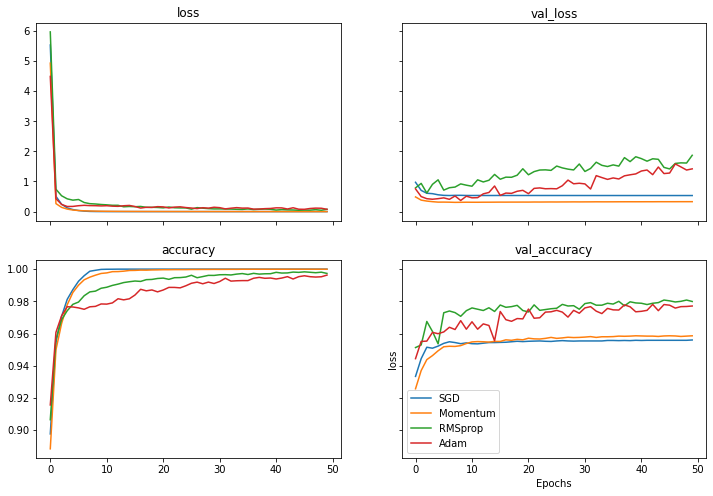

In [ ]:
render_loss(losses, optimizers)

### 四、结果分析

#### 不同优化器的比较

* 收敛速度

* 泛化能力

#### loss和AUC的不一致性

> Suppose there are 3 classes- dog, cat and horse. For our case, the correct class is horse . Now, the output of the softmax is [0.9, 0.1]. For this loss ~0.37. The classifier will predict that it is a horse. Take another case where softmax output is [0.6, 0.4]. Loss ~0.6. The classifier will still predict that it is a horse. But surely, the loss has increased. So, it is all about the output distribution.

https://stats.stackexchange.com/questions/282160/how-is-it-possible-that-validation-loss-is-increasing-while-validation-accuracy